In [5]:
import warnings
import json
import pandas as pd
import torch
import random
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import AutoModelForMaskedLM, AutoTokenizer, DataCollatorForLanguageModeling, Trainer, TrainingArguments

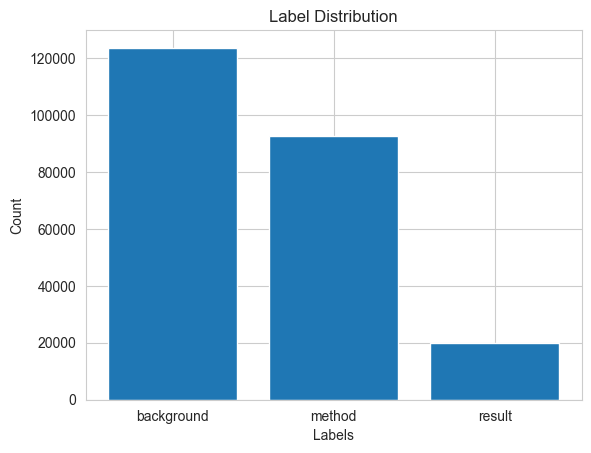

Label counts: {'background': 123605, 'method': 92454, 'result': 19936}


In [6]:
label2id = {"background": 0, "method": 1, "result": 2}
id2label = {v: k for k, v in label2id.items()}

def read_jsonl(file_path):
    citations = []
    intents = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            entry = json.loads(line.strip())
            citation = entry.get('citation')
            citation_intent = entry.get('citation_intent')
            if citation and citation_intent:
                citation_intent_id = label2id.get(citation_intent, -1)  # Use -1 for unknown labels
                citations.append(citation)
                intents.append(citation_intent_id)
    return citations, intents

train_citations, train_intents = read_jsonl('controllable-citation-generation/train.jsonl')
test_citations, test_intents = read_jsonl('controllable-citation-generation/test.jsonl')
val_citations, val_intents = read_jsonl('controllable-citation-generation/val.jsonl')
data = train_intents + test_intents + val_intents

label_counts = Counter(data)
labels, counts = zip(*label_counts.items())
labels = [id2label[label] for label in labels]

plt.bar(labels, counts)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.show()

print("Label counts:", dict(zip(labels, counts)))

In [8]:
DATA_PATH = 'citation_sentiment_corpus_balanced.csv'
df = pd.read_csv(DATA_PATH)
print(df.shape)
df.head()

(11388, 2)


,Citation_Text,Sentiment
0,"al., 1994), compression of sentences with Auto...",1
1,"But in fact, the issue of editing in text summ...",1
2,The recent approach for editing extracted text...,1
3,Recent comparisons of approaches that can be t...,1
4,One of the most effective taggers based on a p...,1


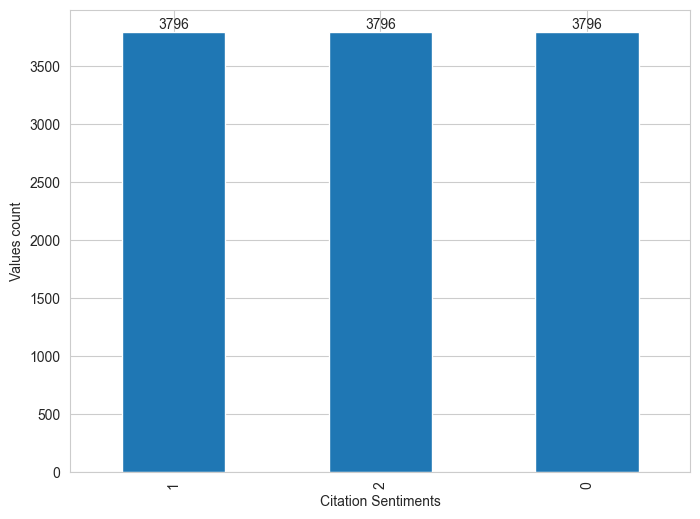

In [9]:
fig, ax = plt.subplots(figsize=(8,6))
df.Sentiment.value_counts().plot(kind = 'bar',ax=ax)
for i, count in enumerate(df.Sentiment.value_counts()):
    ax.text(i, count, str(count), ha='center', va='bottom')
plt.xlabel('Citation Sentiments')
plt.ylabel('Values count')
plt.show()